In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
# train_input = (train_input - np.reshape(np.mean(train_input, 1), (train_input.shape[0], 1)))/np.reshape(np.std(train_input, 1), (train_input.shape[0], 1))
# val_input = (val_input - np.reshape(np.mean(val_input, 1), (val_input.shape[0], 1)))/np.reshape(np.std(val_input, 1), (val_input.shape[0], 1))
# test_input = (test_input - np.reshape(np.mean(test_input, 1), (test_input.shape[0], 1)))/np.reshape(np.std(test_input, 1), (test_input.shape[0], 1))

In [25]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [26]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [31]:
batch_train = batch_train + batch_val

In [32]:
train_output = train_output[:, pred_start:pred_end]
train_output.shape

torch.Size([66175, 1])

In [33]:
val_output = val_output[:, pred_start:pred_end]
val_output.shape

torch.Size([28921, 1])

In [34]:
test_output = test_output[:, pred_start:pred_end]
test_output.shape

torch.Size([1000, 1])

In [35]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [36]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [37]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, latent_dim)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(latent_dim, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [38]:
PATH = 'No_norm_model_RNA_pro_latent'

In [39]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.54417855  Validation_loss:  0.36707035  Test_loss:  0.82523495


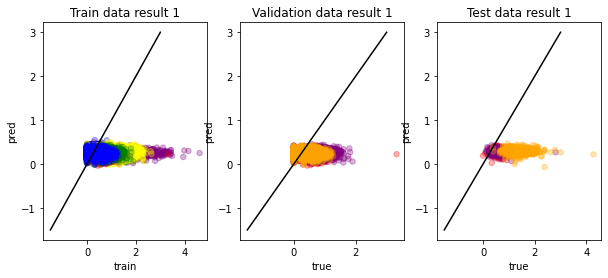

Epoch  100 Train_loss:  0.38523445  Validation_loss:  0.2861249  Test_loss:  0.64938277
Epoch  200 Train_loss:  0.36856103  Validation_loss:  0.2815046  Test_loss:  0.6390372
Epoch  300 Train_loss:  0.3571325  Validation_loss:  0.27811676  Test_loss:  0.6354726
Epoch  400 Train_loss:  0.3487794  Validation_loss:  0.27588072  Test_loss:  0.6378502
Epoch  500 Train_loss:  0.3422853  Validation_loss:  0.27333492  Test_loss:  0.64506
Epoch  600 Train_loss:  0.33683297  Validation_loss:  0.2714433  Test_loss:  0.6480172
Epoch  700 Train_loss:  0.3322695  Validation_loss:  0.26913482  Test_loss:  0.65517265
Epoch  800 Train_loss:  0.32792717  Validation_loss:  0.26783285  Test_loss:  0.65512186
Epoch  900 Train_loss:  0.32410514  Validation_loss:  0.26569062  Test_loss:  0.6600025
Epoch  1000 Train_loss:  0.32046852  Validation_loss:  0.2638666  Test_loss:  0.6630033


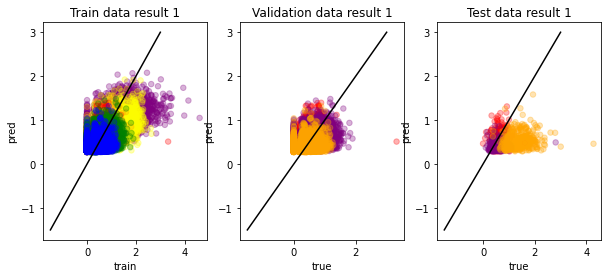

Epoch  1100 Train_loss:  0.3169579  Validation_loss:  0.26218474  Test_loss:  0.66458434
Epoch  1200 Train_loss:  0.3136153  Validation_loss:  0.260536  Test_loss:  0.66675246
Epoch  1300 Train_loss:  0.31035867  Validation_loss:  0.2590289  Test_loss:  0.6670711
Epoch  1400 Train_loss:  0.30714107  Validation_loss:  0.25777882  Test_loss:  0.6661102
Epoch  1500 Train_loss:  0.30415305  Validation_loss:  0.25583667  Test_loss:  0.6702768
Epoch  1600 Train_loss:  0.3011104  Validation_loss:  0.25442588  Test_loss:  0.6693789
Epoch  1700 Train_loss:  0.29812577  Validation_loss:  0.25292367  Test_loss:  0.66987884
Epoch  1800 Train_loss:  0.29533222  Validation_loss:  0.25135267  Test_loss:  0.6734426
Epoch  1900 Train_loss:  0.29249963  Validation_loss:  0.2498201  Test_loss:  0.67400163
Epoch  2000 Train_loss:  0.28972873  Validation_loss:  0.24835196  Test_loss:  0.6745448


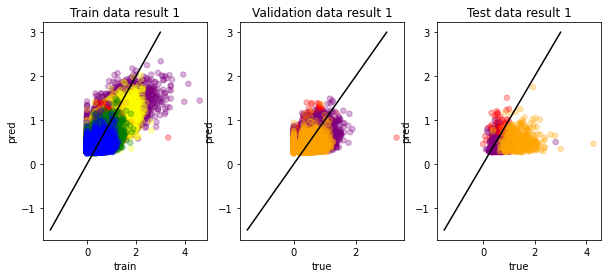

Epoch  2100 Train_loss:  0.28693226  Validation_loss:  0.24701212  Test_loss:  0.67194414
Epoch  2200 Train_loss:  0.28442943  Validation_loss:  0.24519488  Test_loss:  0.67618895
Epoch  2300 Train_loss:  0.28198066  Validation_loss:  0.2436365  Test_loss:  0.67928106
Epoch  2400 Train_loss:  0.27904382  Validation_loss:  0.24240439  Test_loss:  0.6750456
Epoch  2500 Train_loss:  0.27643007  Validation_loss:  0.24103622  Test_loss:  0.6744311
Epoch  2600 Train_loss:  0.2738109  Validation_loss:  0.2395797  Test_loss:  0.6749496
Epoch  2700 Train_loss:  0.2715534  Validation_loss:  0.23778999  Test_loss:  0.678415
Epoch  2800 Train_loss:  0.26915452  Validation_loss:  0.23629889  Test_loss:  0.6801526
Epoch  2900 Train_loss:  0.2664502  Validation_loss:  0.23498504  Test_loss:  0.6781769


In [40]:
num_epochs = 3000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=15, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=15, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.50534314  Validation_loss:  0.35345176  Test_loss:  0.69434685


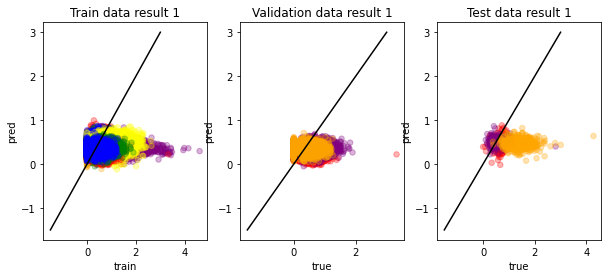

Epoch  100 Train_loss:  0.3823459  Validation_loss:  0.28330302  Test_loss:  0.6599387
Epoch  200 Train_loss:  0.3671477  Validation_loss:  0.27931193  Test_loss:  0.6542277
Epoch  300 Train_loss:  0.35653827  Validation_loss:  0.27622226  Test_loss:  0.65432644
Epoch  400 Train_loss:  0.3485559  Validation_loss:  0.27353343  Test_loss:  0.65944064
Epoch  500 Train_loss:  0.34251395  Validation_loss:  0.27147233  Test_loss:  0.6665102
Epoch  600 Train_loss:  0.33747923  Validation_loss:  0.26954195  Test_loss:  0.67166877
Epoch  700 Train_loss:  0.332953  Validation_loss:  0.26809913  Test_loss:  0.6743087
Epoch  800 Train_loss:  0.32890674  Validation_loss:  0.26688135  Test_loss:  0.674994
Epoch  900 Train_loss:  0.32563338  Validation_loss:  0.2646927  Test_loss:  0.6807133
Epoch  1000 Train_loss:  0.32211995  Validation_loss:  0.26329872  Test_loss:  0.6802094


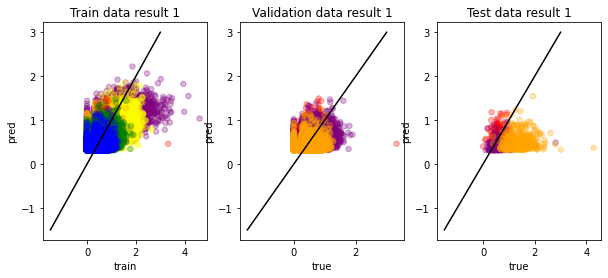

Epoch  1100 Train_loss:  0.31889936  Validation_loss:  0.26177484  Test_loss:  0.68167746
Epoch  1200 Train_loss:  0.31603378  Validation_loss:  0.2601366  Test_loss:  0.6850855
Epoch  1300 Train_loss:  0.31275952  Validation_loss:  0.2590342  Test_loss:  0.68311644
Epoch  1400 Train_loss:  0.31010336  Validation_loss:  0.25763452  Test_loss:  0.68501455
Epoch  1500 Train_loss:  0.30735585  Validation_loss:  0.25629222  Test_loss:  0.6844126
Epoch  1600 Train_loss:  0.3046754  Validation_loss:  0.2550614  Test_loss:  0.6840323
Epoch  1700 Train_loss:  0.3020291  Validation_loss:  0.2540191  Test_loss:  0.6827631
Epoch  1800 Train_loss:  0.29962495  Validation_loss:  0.25271335  Test_loss:  0.6831886
Epoch  1900 Train_loss:  0.29737464  Validation_loss:  0.25152582  Test_loss:  0.6851736
Epoch  2000 Train_loss:  0.2948248  Validation_loss:  0.2507604  Test_loss:  0.682104


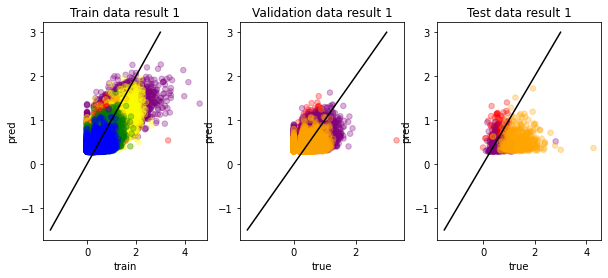

Epoch  2100 Train_loss:  0.2929322  Validation_loss:  0.2492804  Test_loss:  0.6856101
Epoch  2200 Train_loss:  0.29060128  Validation_loss:  0.24828786  Test_loss:  0.68355453
Epoch  2300 Train_loss:  0.28855845  Validation_loss:  0.24712774  Test_loss:  0.68531185
Epoch  2400 Train_loss:  0.28641596  Validation_loss:  0.24614836  Test_loss:  0.6842728
Epoch  2500 Train_loss:  0.28418413  Validation_loss:  0.24524271  Test_loss:  0.68292445
Epoch  2600 Train_loss:  0.2823252  Validation_loss:  0.24413407  Test_loss:  0.6840254
Epoch  2700 Train_loss:  0.2805343  Validation_loss:  0.24299197  Test_loss:  0.68529695
Epoch  2800 Train_loss:  0.27844605  Validation_loss:  0.24211197  Test_loss:  0.6837546
Epoch  2900 Train_loss:  0.2765103  Validation_loss:  0.24106872  Test_loss:  0.68351555


In [41]:
num_epochs = 3000
learning_rate = 0.001
latent_dim = 15
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=10, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.5766354  Validation_loss:  0.43562567  Test_loss:  0.7614805


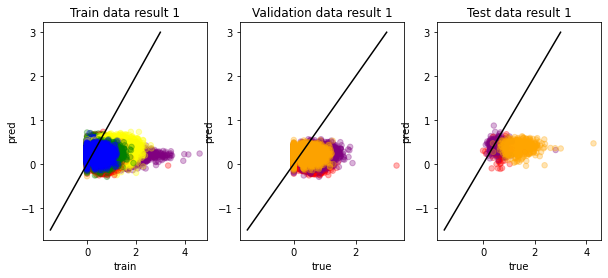

Epoch  100 Train_loss:  0.38550773  Validation_loss:  0.2844249  Test_loss:  0.66550434
Epoch  200 Train_loss:  0.36927176  Validation_loss:  0.27927724  Test_loss:  0.6606038
Epoch  300 Train_loss:  0.35819277  Validation_loss:  0.2755635  Test_loss:  0.6622787
Epoch  400 Train_loss:  0.350202  Validation_loss:  0.27255145  Test_loss:  0.66998786
Epoch  500 Train_loss:  0.34371394  Validation_loss:  0.270721  Test_loss:  0.67062473
Epoch  600 Train_loss:  0.33894235  Validation_loss:  0.26905382  Test_loss:  0.67559236
Epoch  700 Train_loss:  0.33461148  Validation_loss:  0.26781526  Test_loss:  0.67632616
Epoch  800 Train_loss:  0.33085942  Validation_loss:  0.2663802  Test_loss:  0.68020606
Epoch  900 Train_loss:  0.32710406  Validation_loss:  0.26515576  Test_loss:  0.67984664
Epoch  1000 Train_loss:  0.32385194  Validation_loss:  0.2638516  Test_loss:  0.68303955


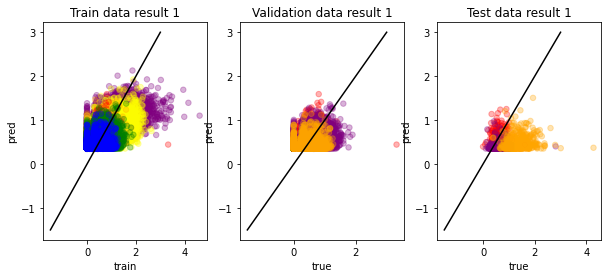

Epoch  1100 Train_loss:  0.32047868  Validation_loss:  0.26292357  Test_loss:  0.6802279
Epoch  1200 Train_loss:  0.31775153  Validation_loss:  0.2613549  Test_loss:  0.68392426
Epoch  1300 Train_loss:  0.31491482  Validation_loss:  0.26027167  Test_loss:  0.6849327
Epoch  1400 Train_loss:  0.3123202  Validation_loss:  0.25892687  Test_loss:  0.68457025
Epoch  1500 Train_loss:  0.3099225  Validation_loss:  0.25778434  Test_loss:  0.6871221
Epoch  1600 Train_loss:  0.3072516  Validation_loss:  0.25685698  Test_loss:  0.68629354
Epoch  1700 Train_loss:  0.3046226  Validation_loss:  0.256012  Test_loss:  0.68374294
Epoch  1800 Train_loss:  0.30251363  Validation_loss:  0.2545911  Test_loss:  0.6860996
Epoch  1900 Train_loss:  0.30026275  Validation_loss:  0.25336558  Test_loss:  0.69022745
Epoch  2000 Train_loss:  0.2977699  Validation_loss:  0.25256404  Test_loss:  0.68707657


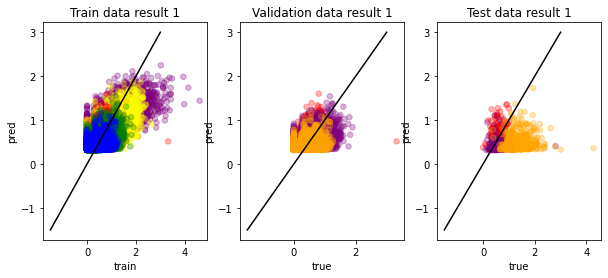

Epoch  2100 Train_loss:  0.2958728  Validation_loss:  0.25139573  Test_loss:  0.6891334
Epoch  2200 Train_loss:  0.29376808  Validation_loss:  0.25038758  Test_loss:  0.6880087
Epoch  2300 Train_loss:  0.2920335  Validation_loss:  0.24951258  Test_loss:  0.69144076
Epoch  2400 Train_loss:  0.2897523  Validation_loss:  0.24863416  Test_loss:  0.6884347
Epoch  2500 Train_loss:  0.2879129  Validation_loss:  0.24775702  Test_loss:  0.68884075
Epoch  2600 Train_loss:  0.28618363  Validation_loss:  0.24692236  Test_loss:  0.6899644
Epoch  2700 Train_loss:  0.28464052  Validation_loss:  0.24601924  Test_loss:  0.69161063
Epoch  2800 Train_loss:  0.2826534  Validation_loss:  0.24533486  Test_loss:  0.6906979
Epoch  2900 Train_loss:  0.28078005  Validation_loss:  0.24476396  Test_loss:  0.68936664


In [42]:
num_epochs = 3000
learning_rate = 0.001
latent_dim = 10
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=25, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.5913678  Validation_loss:  0.42140597  Test_loss:  0.8520168


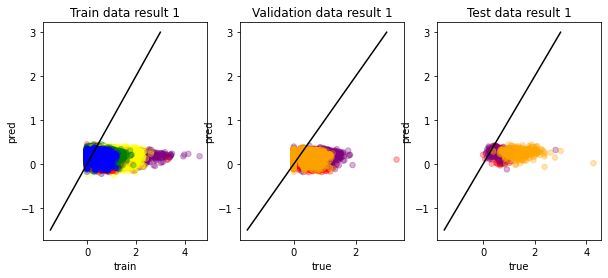

Epoch  100 Train_loss:  0.38413393  Validation_loss:  0.2866093  Test_loss:  0.65586
Epoch  200 Train_loss:  0.36844385  Validation_loss:  0.2812939  Test_loss:  0.64644045
Epoch  300 Train_loss:  0.35755396  Validation_loss:  0.27770212  Test_loss:  0.64687955
Epoch  400 Train_loss:  0.34929973  Validation_loss:  0.27531302  Test_loss:  0.65279496
Epoch  500 Train_loss:  0.34274608  Validation_loss:  0.27335283  Test_loss:  0.6579336
Epoch  600 Train_loss:  0.3375209  Validation_loss:  0.27120686  Test_loss:  0.6655567
Epoch  700 Train_loss:  0.33291525  Validation_loss:  0.2696926  Test_loss:  0.66646194
Epoch  800 Train_loss:  0.32892686  Validation_loss:  0.26777256  Test_loss:  0.67112976
Epoch  900 Train_loss:  0.32526132  Validation_loss:  0.26582065  Test_loss:  0.67559296
Epoch  1000 Train_loss:  0.32168078  Validation_loss:  0.26445097  Test_loss:  0.6744036


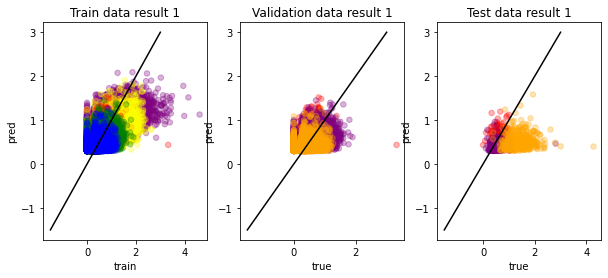

Epoch  1100 Train_loss:  0.31837055  Validation_loss:  0.2627007  Test_loss:  0.67819464
Epoch  1200 Train_loss:  0.31512088  Validation_loss:  0.26117116  Test_loss:  0.6790226
Epoch  1300 Train_loss:  0.31199086  Validation_loss:  0.2597843  Test_loss:  0.6778245
Epoch  1400 Train_loss:  0.30913427  Validation_loss:  0.2581179  Test_loss:  0.68158144
Epoch  1500 Train_loss:  0.3061407  Validation_loss:  0.25688726  Test_loss:  0.67958295
Epoch  1600 Train_loss:  0.30337366  Validation_loss:  0.255445  Test_loss:  0.6822356
Epoch  1700 Train_loss:  0.30061376  Validation_loss:  0.2541251  Test_loss:  0.6812776
Epoch  1800 Train_loss:  0.2980306  Validation_loss:  0.2526412  Test_loss:  0.6828091
Epoch  1900 Train_loss:  0.29549834  Validation_loss:  0.25126678  Test_loss:  0.6854746


In [43]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 25
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=5, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.6174842  Validation_loss:  0.44324008  Test_loss:  0.9380544


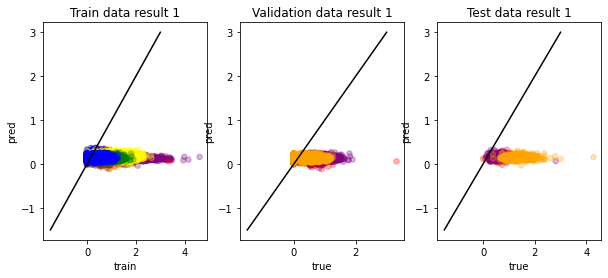

Epoch  100 Train_loss:  0.39121467  Validation_loss:  0.2801889  Test_loss:  0.6759532
Epoch  200 Train_loss:  0.37536892  Validation_loss:  0.2788378  Test_loss:  0.66984427
Epoch  300 Train_loss:  0.36462396  Validation_loss:  0.27500722  Test_loss:  0.6631191
Epoch  400 Train_loss:  0.35621685  Validation_loss:  0.2730794  Test_loss:  0.66152793
Epoch  500 Train_loss:  0.34988058  Validation_loss:  0.27160567  Test_loss:  0.66392076
Epoch  600 Train_loss:  0.34497637  Validation_loss:  0.27031785  Test_loss:  0.66899884
Epoch  700 Train_loss:  0.34061095  Validation_loss:  0.26959446  Test_loss:  0.6708301
Epoch  800 Train_loss:  0.3372766  Validation_loss:  0.26791617  Test_loss:  0.6766735
Epoch  900 Train_loss:  0.3335205  Validation_loss:  0.26724315  Test_loss:  0.6748887
Epoch  1000 Train_loss:  0.3308093  Validation_loss:  0.26580578  Test_loss:  0.68015933


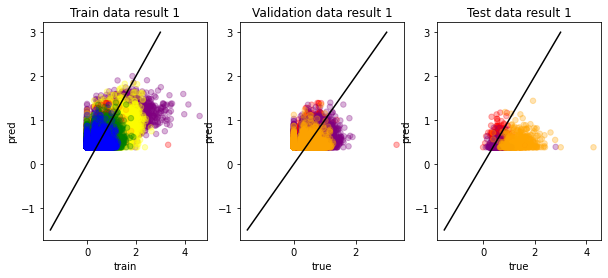

Epoch  1100 Train_loss:  0.32782212  Validation_loss:  0.26454496  Test_loss:  0.67995363
Epoch  1200 Train_loss:  0.32523403  Validation_loss:  0.26356795  Test_loss:  0.6818028
Epoch  1300 Train_loss:  0.32258853  Validation_loss:  0.26267445  Test_loss:  0.68179715
Epoch  1400 Train_loss:  0.32024065  Validation_loss:  0.26170763  Test_loss:  0.68270254
Epoch  1500 Train_loss:  0.31773013  Validation_loss:  0.26081923  Test_loss:  0.6809381
Epoch  1600 Train_loss:  0.31574857  Validation_loss:  0.25974858  Test_loss:  0.6825
Epoch  1700 Train_loss:  0.3134925  Validation_loss:  0.25887686  Test_loss:  0.68176585
Epoch  1800 Train_loss:  0.31173253  Validation_loss:  0.2579168  Test_loss:  0.68291795
Epoch  1900 Train_loss:  0.3099286  Validation_loss:  0.25705755  Test_loss:  0.6834016


In [44]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 5
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Autoencoder(
  (linear1): Linear(in_features=13953, out_features=3, bias=True)
  (linear2): Linear(in_features=6976, out_features=3488, bias=True)
  (linear3): Linear(in_features=3488, out_features=1744, bias=True)
  (linear4): Linear(in_features=1744, out_features=872, bias=True)
  (linear5): Linear(in_features=3, out_features=1, bias=True)
  (relu): ReLU()
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.15, inplace=False)
  (linear): Linear(in_features=13953, out_features=1, bias=True)
)
Epoch  0 Train_loss:  0.92807114  Validation_loss:  0.7670825  Test_loss:  1.2928405


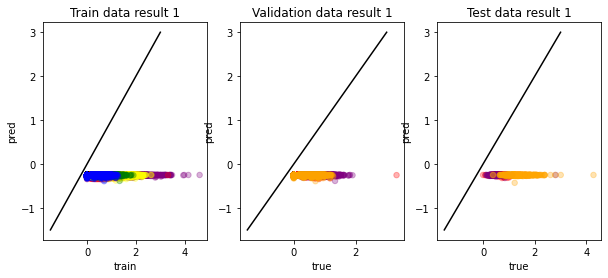

Epoch  100 Train_loss:  0.4399708  Validation_loss:  0.29344335  Test_loss:  0.6291145
Epoch  200 Train_loss:  0.43993554  Validation_loss:  0.2953676  Test_loss:  0.62565833
Epoch  300 Train_loss:  0.43993554  Validation_loss:  0.2952345  Test_loss:  0.62589073
Epoch  400 Train_loss:  0.4399355  Validation_loss:  0.29528832  Test_loss:  0.6257966
Epoch  500 Train_loss:  0.4399355  Validation_loss:  0.2952958  Test_loss:  0.6257835
Epoch  600 Train_loss:  0.4399356  Validation_loss:  0.29538685  Test_loss:  0.6256248
Epoch  700 Train_loss:  0.4399355  Validation_loss:  0.29528946  Test_loss:  0.62579465
Epoch  800 Train_loss:  0.4399355  Validation_loss:  0.2953481  Test_loss:  0.6256923
Epoch  900 Train_loss:  0.43993554  Validation_loss:  0.2952598  Test_loss:  0.62584645
Epoch  1000 Train_loss:  0.4399355  Validation_loss:  0.29527333  Test_loss:  0.62582284


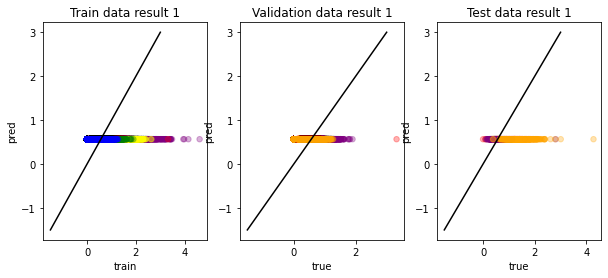

Epoch  1100 Train_loss:  0.4399355  Validation_loss:  0.29529113  Test_loss:  0.6257917
Epoch  1200 Train_loss:  0.4399355  Validation_loss:  0.2952715  Test_loss:  0.625826
Epoch  1300 Train_loss:  0.4399355  Validation_loss:  0.295317  Test_loss:  0.6257466
Epoch  1400 Train_loss:  0.43993554  Validation_loss:  0.29525262  Test_loss:  0.625859
Epoch  1500 Train_loss:  0.4399356  Validation_loss:  0.29537815  Test_loss:  0.62564
Epoch  1600 Train_loss:  0.43993554  Validation_loss:  0.29535824  Test_loss:  0.62567466
Epoch  1700 Train_loss:  0.4399356  Validation_loss:  0.29522645  Test_loss:  0.6259048
Epoch  1800 Train_loss:  0.4399355  Validation_loss:  0.2952815  Test_loss:  0.62580854
Epoch  1900 Train_loss:  0.43993554  Validation_loss:  0.29524696  Test_loss:  0.6258689


In [45]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 3
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
print(model)
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.4862519  Validation_loss:  0.33465424  Test_loss:  0.631719


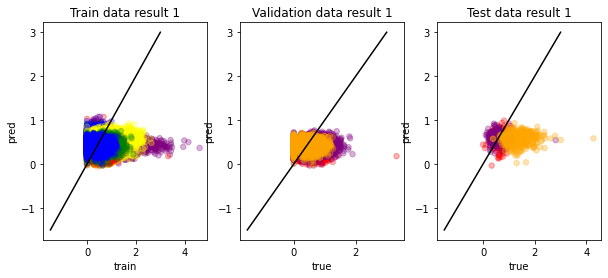

Epoch  100 Train_loss:  0.3781385  Validation_loss:  0.28016987  Test_loss:  0.65787107
Epoch  200 Train_loss:  0.36237544  Validation_loss:  0.27601358  Test_loss:  0.6531582
Epoch  300 Train_loss:  0.35257855  Validation_loss:  0.27318004  Test_loss:  0.65829825
Epoch  400 Train_loss:  0.34631142  Validation_loss:  0.27055934  Test_loss:  0.6726928
Epoch  500 Train_loss:  0.3408336  Validation_loss:  0.26951614  Test_loss:  0.66984206
Epoch  600 Train_loss:  0.33637023  Validation_loss:  0.26816246  Test_loss:  0.6709355
Epoch  700 Train_loss:  0.33271852  Validation_loss:  0.26629823  Test_loss:  0.6773735
Epoch  800 Train_loss:  0.32908288  Validation_loss:  0.26499987  Test_loss:  0.678835
Epoch  900 Train_loss:  0.3255012  Validation_loss:  0.26416853  Test_loss:  0.6772439
Epoch  1000 Train_loss:  0.32273144  Validation_loss:  0.26260266  Test_loss:  0.68324596


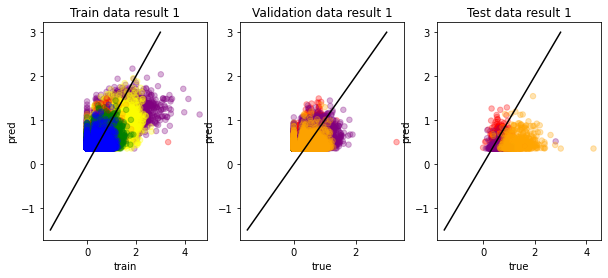

Epoch  1100 Train_loss:  0.31965277  Validation_loss:  0.26164627  Test_loss:  0.68274194
Epoch  1200 Train_loss:  0.3170458  Validation_loss:  0.26053578  Test_loss:  0.6837623
Epoch  1300 Train_loss:  0.3142857  Validation_loss:  0.25950667  Test_loss:  0.6833214
Epoch  1400 Train_loss:  0.31205994  Validation_loss:  0.25823042  Test_loss:  0.6861091
Epoch  1500 Train_loss:  0.309821  Validation_loss:  0.25712398  Test_loss:  0.6870921
Epoch  1600 Train_loss:  0.3074362  Validation_loss:  0.25631198  Test_loss:  0.68643653
Epoch  1700 Train_loss:  0.30524912  Validation_loss:  0.25533876  Test_loss:  0.68555784
Epoch  1800 Train_loss:  0.30396584  Validation_loss:  0.25403702  Test_loss:  0.68998486
Epoch  1900 Train_loss:  0.3011008  Validation_loss:  0.2537447  Test_loss:  0.6843301


In [40]:
num_epochs = 2000
learning_rate = 0.001
latent_dim = 4
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)